In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

# ML
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Any, Callable, Dict, List, Literal, Optional, Tuple, Union
from einops import rearrange, reduce, repeat
from jaxtyping import Float, Int, Bool
from torch.utils.data import DataLoader

import wandb

# Numeric
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


# Nicks proof

$grad · d/||d||$

tells me "how much" of grad is in the direction d

$d/||d|| (grad · d/||d||) = d (grad · d)/||d||^2$

is then the component of grad in direction (I multiplied how much, by the direction). When I subtract that, I'm getting the part of grad which has no d:

$grad - d (grad · d)/||d||^2$

I can prove this by taking the dot product with d again:

$grad · d - (d · d) (grad · d)/||d||^2 = grad · d - ||d||^2 (grad · d)/||d||^2 = grad · d - grad · d = 0$

Easier if $||d|| = 1$

$grad · d$

tells me "how much" of grad is in the direction d

$d (grad · d) = d (grad · d)$

is then the component of grad in direction (I multiplied how much, by the direction). When I subtract that, I'm getting the part of grad which has no d:

$grad - d (grad · d)$

I can prove this by taking the dot product with d again:

$grad · d - (d · d) (grad · d) = grad · d - ||d||^2 (grad · d) = grad · d - grad · d = 0$


In [3]:
cho = torch.randn(2, 3, 4, 64) # b l t h
d = torch.randn(2, 3, 4, 64) # b l t h
d /= d.norm(dim=-1, keepdim=True)

cho_para = d * ( cho * d).sum(dim=-1, keepdim=True)
cho_oth = cho - cho_para
# prove it by taking dot product of orth
r = (cho_oth * d).sum(dim=-1, keepdim=True)
r.norm(), cho_oth.norm(), cho_para.norm()


(tensor(5.6722e-07), tensor(37.7603), tensor(4.7878))

In [21]:
(cho_oth+cho_para-cho).norm()

tensor(5.7500e-07)

# other

In [3]:
hs = torch.randn(2, 3, 4, 64) # b l t h

torch.norm(hs, dim=-1)

tensor([[[7.4040, 7.9128, 7.7753, 7.4688],
         [7.3472, 7.1764, 8.0988, 8.5598],
         [9.3660, 8.8174, 7.7997, 7.6633]],

        [[7.6303, 6.8419, 9.0447, 8.0975],
         [8.8064, 8.1964, 6.7658, 7.5134],
         [7.6322, 8.0401, 8.2847, 7.3227]]])

In [4]:
torch.pow(np.abs(hs), 2).mean(-1).sqrt()

tensor([[[0.9255, 0.9891, 0.9719, 0.9336],
         [0.9184, 0.8971, 1.0123, 1.0700],
         [1.1708, 1.1022, 0.9750, 0.9579]],

        [[0.9538, 0.8552, 1.1306, 1.0122],
         [1.1008, 1.0245, 0.8457, 0.9392],
         [0.9540, 1.0050, 1.0356, 0.9153]]])

In [36]:
np.sqrt(0)

0.0

In [34]:
torch.pow(np.abs(hs), 2).sum(-1).sqrt()

tensor([[[7.3075, 8.3307, 7.5948, 8.2794],
         [8.2917, 8.5048, 7.9685, 7.6835],
         [6.7701, 8.7494, 6.8323, 7.6135]],

        [[7.3060, 8.6134, 8.4490, 7.0520],
         [6.6969, 6.7753, 8.8448, 8.1489],
         [7.5666, 8.3536, 7.2877, 8.8651]]])

In [30]:
torch.pow(np.abs(hs), 2).mean(-1)

tensor([[[0.8344, 1.0844, 0.9013, 1.0711],
         [1.0743, 1.1302, 0.9921, 0.9224],
         [0.7162, 1.1961, 0.7294, 0.9057]],

        [[0.8340, 1.1592, 1.1154, 0.7770],
         [0.7008, 0.7173, 1.2223, 1.0376],
         [0.8946, 1.0903, 0.8298, 1.2280]]])

In [28]:
torch.norm_except_dim(hs, dim=0).shape

torch.Size([2, 1, 1, 1])

In [16]:
torch.pow(np.abs(hs), 2).mean(1)

tensor([0.8035, 0.9562])

## Hinge on nll

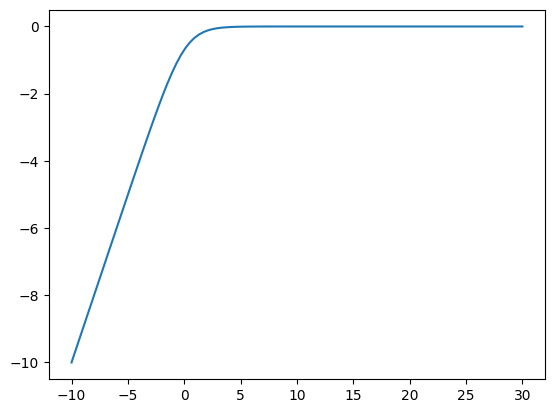

In [26]:
from torch.nn import functional as F
import torch
ref_nll_loss = torch.tensor(11)

nll_loss = torch.tensor(20)

x = torch.linspace(-10, 30, 100) # nll_loss - ref_nll_loss
y = F.softplus(x+ -1 * torch.log(torch.tensor(0.9)))
y = F.logsigmoid(x)

from matplotlib import pyplot as plt
plt.plot(x, y)

In [44]:
import numpy as np
np.exp(5)
np.log(1.1)

0.09531017980432493

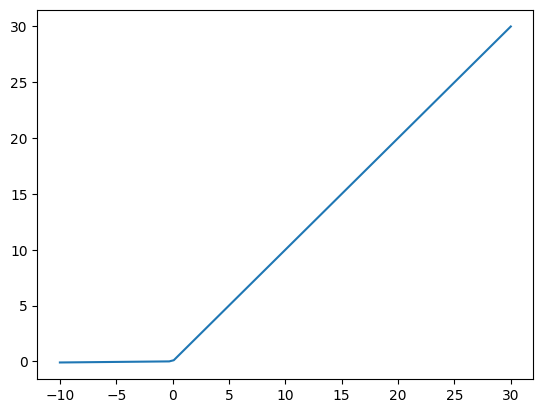

In [48]:
y = F.leaky_relu(x + 0.)
plt.plot(x, y)

## projecting dirs

In [21]:

pi_hs_cho = torch.tensor([0.1, 0.2]) # policy hidden states chosen
pi_hs_rej = torch.tensor([0.4, 0.3]) # same but rejected
dir = pi_hs_cho - pi_hs_rej
ref_hs_cho = torch.tensor([0.1, 0.1]) # reference_model hidden states chosen
ref_hs_rej = torch.tensor([0.5, 0.4])
ref_dir = ref_hs_cho - ref_hs_rej

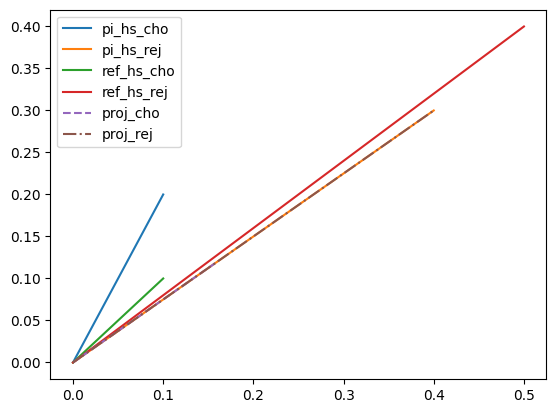

In [107]:

# Project both onto ref_dir
proj_cho = torch.dot(pi_hs_cho, ref_dir) / torch.dot(ref_dir, ref_dir) * ref_dir
proj_rej = torch.dot(pi_hs_rej, ref_dir) / torch.dot(ref_dir, ref_dir) * ref_dir

# Measure distance from original to projected points
dist_cho = torch.norm(proj_cho - pi_hs_cho)
dist_rej = torch.norm(proj_rej - pi_hs_rej)

loss = -(dist_cho + dist_rej)  # Negative to maximize movement

plt.plot([0, pi_hs_cho[0]], [0, pi_hs_cho[1]], label='pi_hs_cho')
plt.plot([0, pi_hs_rej[0]], [0, pi_hs_rej[1]], label='pi_hs_rej')
plt.plot([0, ref_hs_cho[0]], [0, ref_hs_cho[1]], label='ref_hs_cho')
plt.plot([0, ref_hs_rej[0]], [0, ref_hs_rej[1]], label='ref_hs_rej')
plt.plot([0, proj_cho[0]], [0, proj_cho[1]], label='proj_cho', ls='--')
plt.plot([0, proj_rej[0]], [0, proj_rej[1]], label='proj_rej', ls='-.')
plt.legend()

In [125]:
proj_cho

tensor([0.1600, 0.1200])

distances
proj_cho tensor(-0.0600)
proj_rej tensor(0.1400)
dist_cho=-0.10, dist_rej=0.14
proj_cho=-0.06, ortho_cho=0.08
proj_rej=0.14, ortho_rej=-0.02


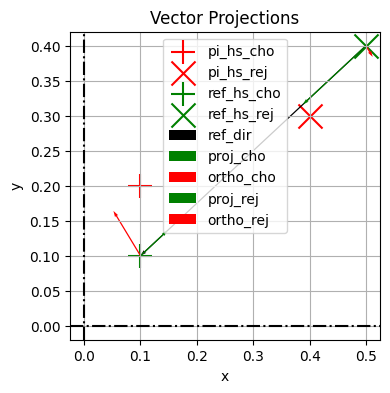

In [334]:
import matplotlib.pyplot as plt

def plot_vectors(pi_hs_cho, pi_hs_rej, ref_dir):
    # plt.figure(figsize=(10, 10))
    
    # Plot original vectors
    qs = 0.5
    s= 300
    plt.figure(figsize=(4, 4))
    plt.scatter(*pi_hs_cho, label='pi_hs_cho', marker='+', c='red', s=s)
    plt.scatter(*pi_hs_rej, label='pi_hs_rej', marker='x', c='red', s=s)
    q_kwargs=dict(
        # headwidth=3*qs, headlength=5*qs, headaxislength=4.5*qs,
                  angles='xy', scale_units='xy', 
                  width=0.004,
                scale=1,
                  )
    plt.scatter(*ref_hs_cho, label='ref_hs_cho', marker='+', c='green', s=s)
    plt.scatter(*ref_hs_rej, label='ref_hs_rej', marker='x', c='green', s=s)
    plt.quiver(*ref_hs_rej, ref_dir[0], ref_dir[1], color='k', label='ref_dir', **q_kwargs)
    # plt.quiver(0, 0, pi_hs_cho[0], pi_hs_cho[1], angles='xy', scale_units='xy', scale=1, color='r', label='pi_hs_cho')
    # plt.quiver(0, 0, pi_hs_rej[0], pi_hs_rej[1], angles='xy', scale_units='xy', scale=1, color='b', label='pi_hs_rej')
    
    # Plot projections
    dot = torch.linalg.vecdot

    def proj(a, b):
        """Project a onto b"""
        b_unit = b / b.pow(2).sum(-1, keepdim=True)
        a_dist_b = torch.linalg.vecdot(a, b, dim=-1)[..., None] 
        return a_dist_b * b_unit

    def dist(a):
        """Distance from origin"""
        return torch.norm(a, dim=-1) * torch.sign(dot(a, ref_dir))
    
    cho = pi_hs_cho-ref_hs_cho
    proj_cho = proj(cho, ref_dir)
    ortho_cho = cho - proj_cho
    rej = pi_hs_rej-ref_hs_rej
    proj_rej = proj(rej, ref_dir)
    ortho_rej = rej - proj_rej

    print('distances')
    print('proj_cho', torch.dot(cho, ref_dir) / torch.dot(ref_dir, ref_dir) * torch.norm(ref_dir)) 
    print('proj_rej', torch.dot(rej, ref_dir) / torch.dot(ref_dir, ref_dir) * torch.norm(ref_dir) )
    
    print(f"dist_cho={dist(cho):2.2f}, dist_rej={dist(rej):2.2f}")
    print(f"proj_cho={dist(proj_cho):2.2f}, ortho_cho={dist(ortho_cho):2.2f}")
    print(f"proj_rej={dist(proj_rej):2.2f}, ortho_rej={dist(ortho_rej):2.2f}")

    
    plt.quiver(*ref_hs_cho, *proj_cho,
                color='green', 
                label='proj_cho', 
                # alpha=0.5,
                **q_kwargs
                )
    plt.quiver(*ref_hs_cho, *ortho_cho, 
                color='red', 
                label='ortho_cho', 
                **q_kwargs
                )
  
    plt.quiver(*ref_hs_rej, *proj_rej,
              #  proj_rej[0], proj_rej[1], 
                  label='proj_rej', color='g', **q_kwargs)
    plt.quiver(*ref_hs_rej, *ortho_rej, 
                color='red', 
                label='ortho_rej', 
                **q_kwargs
                )
    
    plt.axhline(y=0, color='k', linestyle='-.')
    plt.axvline(x=0, color='k', linestyle='-.')
    plt.legend()
    plt.grid(True)
    # plt.axis('equal')
    plt.title('Vector Projections')
    plt.xlabel('x')
    plt.ylabel('y')
    # plt.xlim(0, 1)
    # plt.ylim(0, 1)
    plt.show()

plot_vectors(pi_hs_cho, pi_hs_rej, ref_dir)

distances
- proj_cho tensor(-0.0600)
- proj_rej tensor(0.1400)
- dist_cho=-0.10, dist_rej=0.14
- proj_cho=-0.06, ortho_cho=0.08
- proj_rej=0.14, ortho_rej=-0.02

In [348]:
ref_dir_norm = torch.sqrt(torch.linalg.vecdot(ref_dir, ref_dir))
torch.linalg.vecdot(cho, ref_dir) / ref_dir_norm

tensor(-0.0600)

In [355]:
cho = pi_hs_cho-ref_hs_cho
costheta = F.cosine_similarity(cho, ref_dir, dim=-1)
sintheta = torch.sqrt(1 - costheta**2)
d = torch.linalg.norm(cho)
sintheta * d, costheta * d

(tensor(0.0800), tensor(-0.0600))

In [341]:
cho = pi_hs_cho-ref_hs_cho
# proj_cho = proj(cho, ref_dir)
# ortho_cho = cho - proj_cho
rej = pi_hs_rej-ref_hs_rej
# proj_rej = proj(rej, ref_dir)
# ortho_rej = rej - proj_rej

print('proj cho ', F.cosine_similarity(cho, ref_dir, dim=-1) * torch.norm(cho, dim=-1, p=2))
print('ortho cho', (1+F.cosine_similarity(cho, ref_dir, dim=-1)) * torch.norm(cho, dim=-1, p=1))

print(F.cosine_similarity(rej, ref_dir, dim=-1))
print(F.cosine_similarity(rej, ref_dir, dim=-1) * torch.norm(rej, dim=-1, p=2))

proj cho  tensor(-0.0600)
ortho cho tensor(0.0400)
tensor(0.9899)
tensor(0.1400)


In [281]:
b = ref_dir
ref_dir_norm = torch.sum(b**2, dim=-1, keepdim=True)
b_unit = b / ref_dir_norm
b_unit.norm()

tensor(2.)

In [302]:
dot = torch.linalg.vecdot

def proj1(a, b):
    """Project a onto b"""
    b_unit = b / b.pow(2).sum(-1, keepdim=True)
    a_dist_b = torch.linalg.vecdot(a, b, dim=-1)[..., None] 
    return a_dist_b * b_unit

def proj1(a, b):
    """Project a onto b"""
    # b_unit = b / b.pow(2).sum(-1)
    return dot(a, b, dim=-1)[..., None] / dot(b, b, dim=-1)[..., None] * b

def proj1(a, b):
    """Project a onto b"""
    b_unit = b / torch.sum(b**2, dim=-1, keepdim=True)
    # b_unit = b /  dot(b, b, dim=-1)[..., None]
    # b_unit = b / b.pow(2).sum(-1)
    # ref_dir_norm = dot(b, b, dim=-1)[..., None] / b
    # ref_dir_norm = torch.norm(b, keepdim=True)
    return dot(a, b, dim=-1)[..., None] * b_unit
#dot(b, b, dim=-1)[..., None] * b

def proj2(a, b):
    ref_dir_norm = torch.sum(b**2, dim=-1, keepdim=True)
    # ref_dir_norm = torch.norm(b, p=2, dim=-1, keepdim=True)**2
    return torch.sum(a * b, dim=-1, keepdim=True) * b / ref_dir_norm

cho = pi_hs_cho-ref_hs_cho
a,b=proj1(cho, ref_dir), proj2(cho, ref_dir)
dist = torch.norm
print(a,b,dist(a), dist(b))

tensor([0.0480, 0.0360]) tensor([0.0480, 0.0360]) tensor(0.0600) tensor(0.0600)


In [313]:
dot(cho, ref_dir, dim=-1)

RuntimeError: linalg.cross: inputs dimension -1 must have length 3. Got 2 and 2

In [311]:
print(torch.norm(a))
print(torch.sum(a**2).sqrt())
print(torch.sum(a))

tensor(0.0600)
tensor(0.0600)
tensor(0.0840)


tensor([0.0480, 0.0360])

In [253]:
# we want dist with sign

def dist1(a, b):
    # print(torch.linalg.vecdot(a, b))
    return torch.norm(a, dim=-1, p=1) * torch.sign(torch.linalg.vecdot(a, b))

def dist2(a, b):
    c = torch.sum(a * b, dim=-1, keepdim=True) * b / torch.norm(b, dim=-1, keepdim=True)
    print(torch.norm(c))
    return c # torch.sum(a * b, dim=-1)


dist1(pi_hs_cho, ref_dir), dist2(pi_hs_cho, ref_dir)

tensor(0.1000)


(tensor(-0.3000), tensor([0.0800, 0.0600]))

In [323]:
cho.shape, ref_dir.shape

(torch.Size([2]), torch.Size([2]))

In [327]:
F.cosine_similarity(cho, ref_dir, dim=-1)
1-F.cosine_similarity(cho, ref_dir, dim=-1)

tensor(1.6000)

In [321]:
# def get_orthogonal(v, ref_dir):
#     return v - (torch.dot(v, ref_dir) / torch.dot(ref_dir, ref_dir)) * ref_dir

ref_dir_norm = torch.sqrt(torch.linalg.vecdot(ref_dir, ref_dir))
# ref_dir_orth = get_orthogonal(ref_dir, ref_dir)

def signed_proj_magnitude(cho, ref_dir):
    # get signed projection of a along ref_dir
    cho_proj = torch.linalg.vecdot(cho, ref_dir) / ref_dir_norm
    # get unsigned length using pythagorian theorem (we don't care about magnitude here)
    cho_orth= torch.sqrt(torch.norm(cho)**2-cho_proj**2)
    return cho_proj, cho_orth

signed_proj_magnitude(cho, ref_dir)

(tensor(-0.0600), tensor(0.0800))

In [17]:
cho.shape

torch.Size([2, 3, 4, 64])

In [24]:
## norm

cho.norm(dim=-1)
torch.norm_except_dim(cho, dim=0)

tensor([[[[27.1383]]],


        [[[26.6885]]]])

In [28]:
from einops import reduce, rearrange, repeat

reduce(cho**2, 'b l t h -> b', 'sum').sqrt()

tensor([27.1383, 26.6885])

In [31]:
def norm(x, dims):
    return (x ** 2).sum(dims).sqrt()

reduce(cho, 'b l t h -> b', norm)

tensor([27.1383, 26.6885])

,amount
time,
2024-10-20 21:06:00,50
2024-10-21 02:16:00,50
2024-10-21 05:12:00,60
2024-10-21 10:36:00,70
2024-10-21 16:02:00,70
2024-10-21 19:12:00,60
2024-10-21 22:00:00,60
2024-10-22 02:36:00,10
2024-10-22 03:31:00,40


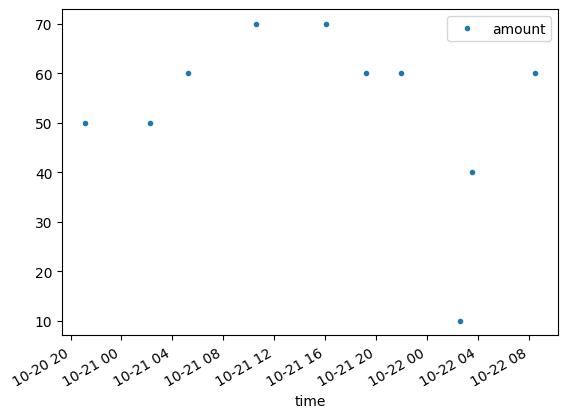

In [14]:
s="""[ Sunday, 20 October 2024 7:18 PM ] 25 
[ Sunday, 20 October 2024 9:06 PM ] 50
[ Monday, 21 October 2024 2:16 AM ] 50
[ Monday, 21 October 2024 5:12 AM ]  60
[ Monday, 21 October 2024 10:36 AM ] 70
[ Monday, 21 October 2024 4:02 PM ] 70
[ Monday, 21 October 2024 7:12 PM ] 60
[ Monday, 21 October 2024 10:00 PM ] 60
[ Tuesday, 22 October 2024 2:36 AM ] 10
[ Tuesday, 22 October 2024 3:31 AM ] 40
[ Tuesday, 22 October 2024 8:32 AM ] 60"""

import re
import pandas as pd
def parse_feed_log(log_text):
    feeds = []
    
    for line in log_text.split('\n'):
            
        # Look for numbers followed by 'ml' (case insensitive)
        import re
        amount_match = re.search(r'(\d+)$', line)
        if amount_match:
            # Extract timestamp from between brackets
            timestamp = re.search(r'\[(.*?)\]', line).group(1).strip()
            timestamp = pd.Timestamp(timestamp)
            amount = int(amount_match.group(1))
            feeds.append({'time': timestamp, 'amount': amount})
    
    return feeds
ss = parse_feed_log(s)
df = pd.DataFrame(ss).set_index('time')
df.plot(style='.')
df

In [11]:
df

,time,amount
0,2024-10-20 21:06:00,50
1,2024-10-21 02:16:00,50
2,2024-10-21 05:12:00,60
3,2024-10-21 10:36:00,70
4,2024-10-21 16:02:00,70
5,2024-10-21 19:12:00,60
6,2024-10-21 22:00:00,60
7,2024-10-22 02:36:00,10
8,2024-10-22 03:31:00,40
9,2024-10-22 08:32:00,60
